In [ ]:
!pip install pyspark &> /dev/null

In [ ]:
from IPython import display
import math
import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.types import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sc =SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
customSchema = StructType([
    StructField("clean_text", StringType()),
    StructField("category", StringType())])

In [ ]:
filename1 = '/content/drive/MyDrive/BDA/BDA_Project/toxicity_annotated_comments.tsv'
df1 = sqlContext.read.format("csv").option("header", "true").option("delimiter", "\t").load(filename1)
df1.count()

159686

In [ ]:
filename2 = '/content/drive/MyDrive/BDA/BDA_Project/toxicity_annotations.tsv'
df2 = sqlContext.read.format("csv").option("header", "true").option("delimiter", "\t").load(filename2)
df2.count()

1598289

In [ ]:
df1.show(10)

+-------+--------------------+----+---------+-------+------+-----+
| rev_id|             comment|year|logged_in|     ns|sample|split|
+-------+--------------------+----+---------+-------+------+-----+
| 2232.0|This:NEWLINE_TOKE...|2002|     True|article|random|train|
| 4216.0|`NEWLINE_TOKENNEW...|2002|     True|   user|random|train|
| 8953.0|Elected or Electo...|2002|    False|article|random| test|
|26547.0|`This is such a f...|2002|     True|article|random|train|
|28959.0|Please relate the...|2002|     True|article|random| test|
|35367.0|`:In an interpret...|2002|     True|article|random|  dev|
|37330.0|`NEWLINE_TOKENNEW...|2002|     True|article|random|train|
|37346.0|`If they are ``in...|2002|     True|article|random|train|
|37675.0|`-NEWLINE_TOKENTh...|2002|    False|article|random|  dev|
|44377.0|`NEWLINE_TOKENNEW...|2002|     True|article|random|train|
+-------+--------------------+----+---------+-------+------+-----+
only showing top 10 rows



In [ ]:
df2.show(20)

+------+---------+--------+--------------+
|rev_id|worker_id|toxicity|toxicity_score|
+------+---------+--------+--------------+
|2232.0|      723|       0|           0.0|
|2232.0|     4000|       0|           0.0|
|2232.0|     3989|       0|           1.0|
|2232.0|     3341|       0|           0.0|
|2232.0|     1574|       0|           1.0|
|2232.0|     1508|       0|           1.0|
|2232.0|      772|       0|           1.0|
|2232.0|      680|       0|           0.0|
|2232.0|      405|       0|           1.0|
|2232.0|     4020|       1|          -1.0|
|4216.0|      500|       0|           0.0|
|4216.0|      599|       0|           0.0|
|4216.0|      339|       0|           2.0|
|4216.0|      257|       0|           0.0|
|4216.0|      303|       0|           1.0|
|4216.0|      188|       0|           0.0|
|4216.0|     1549|       0|           1.0|
|4216.0|       64|       0|           1.0|
|4216.0|     1527|       0|           0.0|
|4216.0|     1502|       0|           0.0|
+------+---

In [ ]:
unique_categories = df2.select('toxicity').distinct().collect()

In [ ]:
unique_categories

[Row(toxicity='0'), Row(toxicity='1')]

In [ ]:
df_score = df2.groupBy('rev_id').agg({'toxicity_score': 'avg'})

In [ ]:
df_score.count()

159686

In [ ]:
joined_df = df1.join(df_score, on='rev_id', how='inner')

In [ ]:
joined_df.show()

+----------+--------------------+----+---------+-------+-------+-----+-------------------+
|    rev_id|             comment|year|logged_in|     ns| sample|split|avg(toxicity_score)|
+----------+--------------------+----+---------+-------+-------+-----+-------------------+
|  857940.0|NEWLINE_TOKENNEWL...|2003|     True|   user| random|  dev|                0.4|
| 2309781.0|`NEWLINE_TOKENNEW...|2004|     True|article| random|  dev|                0.2|
| 3469544.0|`NEWLINE_TOKENNEW...|2004|     True|article| random| test|                0.4|
| 3561485.0|NEWLINE_TOKENNEWL...|2004|     True|   user| random|train|                0.5|
| 8336206.0|`::::::::You inco...|2004|     True|article|blocked|train|                0.3|
| 9388445.0|NEWLINE_TOKENNEWL...|2005|     True|   user| random|  dev|                0.5|
| 9945486.0|NEWLINE_TOKENNEWL...|2005|    False|article|blocked|  dev|                0.4|
|11225280.0|What properties o...|2005|    False|article| random|train|                0.4|

In [ ]:
#0 for healthy and 1 for toxic
from pyspark.sql.functions import udf

# Define the lambda function
my_func = lambda x: 0 if x >= 0 else 1

# Define the UDF
my_udf = udf(my_func)

# Apply the UDF to a column in the DataFrame
joined_df = joined_df.withColumn('Category', my_udf('avg(toxicity_score)'))



In [ ]:
joined_df.show(20)

+----------+--------------------+----+---------+-------+-------+-----+-------------------+--------+
|    rev_id|             comment|year|logged_in|     ns| sample|split|avg(toxicity_score)|Category|
+----------+--------------------+----+---------+-------+-------+-----+-------------------+--------+
|  857940.0|NEWLINE_TOKENNEWL...|2003|     True|   user| random|  dev|                0.4|       0|
| 2309781.0|`NEWLINE_TOKENNEW...|2004|     True|article| random|  dev|                0.2|       0|
| 3469544.0|`NEWLINE_TOKENNEW...|2004|     True|article| random| test|                0.4|       0|
| 3561485.0|NEWLINE_TOKENNEWL...|2004|     True|   user| random|train|                0.5|       0|
| 8336206.0|`::::::::You inco...|2004|     True|article|blocked|train|                0.3|       0|
| 9388445.0|NEWLINE_TOKENNEWL...|2005|     True|   user| random|  dev|                0.5|       0|
| 9945486.0|NEWLINE_TOKENNEWL...|2005|    False|article|blocked|  dev|                0.4|       0|


In [ ]:
joined_df.groupBy('Category').count().show()

+--------+------+
|Category| count|
+--------+------+
|       0|130229|
|       1| 29457|
+--------+------+



# Model Pipeline

In [ ]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import lower
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

joined_df = joined_df.withColumn('comment', regexp_replace('comment', 'NEWLINE_TOKEN', ' '))
joined_df = joined_df.withColumn('comment', regexp_replace('comment', "[^a-zA-Z']", ' '))
joined_df = joined_df.withColumn('comment', regexp_replace('comment', "'", ''))
joined_df = joined_df.withColumn('comment', regexp_replace('comment', "\s+", ' '))
joined_df = joined_df.withColumn("comment", lower(joined_df["comment"]))

In [ ]:
joined_df.show(20)

+----------+--------------------+----+---------+-------+-------+-----+-------------------+--------+
|    rev_id|             comment|year|logged_in|     ns| sample|split|avg(toxicity_score)|Category|
+----------+--------------------+----+---------+-------+-------+-----+-------------------+--------+
|  857940.0| i did state that...|2003|     True|   user| random|  dev|                0.4|       0|
| 2309781.0| cmon dont capitu...|2004|     True|article| random|  dev|                0.2|       0|
| 3469544.0| there are many t...|2004|     True|article| random| test|                0.4|       0|
| 3561485.0| your latter gues...|2004|     True|   user| random|train|                0.5|       0|
| 8336206.0| you incorrectly ...|2004|     True|article|blocked|train|                0.3|       0|
| 9388445.0| hello please rev...|2005|     True|   user| random|  dev|                0.5|       0|
| 9945486.0| yeah that true t...|2005|    False|article|blocked|  dev|                0.4|       0|


In [ ]:
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the","is","a","i","if","of","and"]

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=50000, minDF=10)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(joined_df)
dataset = pipelineFit.transform(joined_df)
dataset.show(5)

+---------+--------------------+----+---------+-------+-------+-----+-------------------+--------+--------------------+--------------------+--------------------+-----+
|   rev_id|             comment|year|logged_in|     ns| sample|split|avg(toxicity_score)|Category|               words|            filtered|            features|label|
+---------+--------------------+----+---------+-------+-------+-----+-------------------+--------+--------------------+--------------------+--------------------+-----+
| 857940.0| i did state that...|2003|     True|   user| random|  dev|                0.4|       0|[i, did, state, t...|[did, state, that...|(22270,[2,3,4,5,7...|  0.0|
|2309781.0| cmon dont capitu...|2004|     True|article| random|  dev|                0.2|       0|[cmon, dont, capi...|[cmon, dont, capi...|(22270,[0,1,2,4,7...|  0.0|
|3469544.0| there are many t...|2004|     True|article| random| test|                0.4|       0|[there, are, many...|[there, are, many...|(22270,[0,1,2,3,4...

In [ ]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Model Training and Evaluation

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("comment","Category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

In [ ]:
# Naive bayes
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Assuming 'my_dataframe' is a PySpark DataFrame with a column named 'my_column' of string type
joined_df = joined_df.withColumn('Category', col('Category').cast('integer'))
nb_df = joined_df.withColumnRenamed('Category', 'label')

train_data, test_data = nb_df.randomSplit([0.7, 0.3], seed=42)

tokenizer = Tokenizer(inputCol='comment', outputCol='words')
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol='features')
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol='tfidf_features')
nb = NaiveBayes(smoothing=1)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print('AUC-ROC score:', auc_roc)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'The accuracy of the Naive Bayes classifier on the test data is {accuracy:.3f}')

AUC-ROC score: 0.7495370364256335
The accuracy of the Naive Bayes classifier on the test data is 0.889


In [ ]:
# SVM

from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LinearSVCTrainingSummary
from pyspark.ml.classification import LinearSVC

# 1. Preprocess the data by converting text to features (e.g., using TF-IDF)
tokenizer = Tokenizer(inputCol='comment', outputCol='words')
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol='rawFeatures', numFeatures=5000)
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol='features')

# 2. Convert the label column to numeric values (e.g., 0 for non-toxic and 1 for toxic)
label_indexer = StringIndexer(inputCol='Category', outputCol='label')

# 3. Split the data into training and testing sets
(train_data, test_data) = joined_df.randomSplit([0.7, 0.3], seed=1234)

# 4. Train the SVM model on the training data
svm = LinearSVC(maxIter=10, regParam=0.1)

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, label_indexer, svm])
model = pipeline.fit(train_data)

# 5. Evaluate the model on the testing data
predictions = model.transform(test_data)
predictions.select('label', 'prediction', 'comment').show(10)

accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_data.count())
print('Accuracy:', accuracy)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})
print('AUC-ROC score:', auc_roc)

+-----+----------+--------------------+
|label|prediction|             comment|
+-----+----------+--------------------+
|  0.0|       0.0| copyright this p...|
|  0.0|       0.0| talk bethlehem c...|
|  0.0|       0.0| ok i will take i...|
|  0.0|       0.0|please stop remov...|
|  0.0|       0.0| an email from wh...|
|  0.0|       0.0| im the one that ...|
|  0.0|       0.0| merope i submitt...|
|  0.0|       0.0| image apal jpg t...|
|  0.0|       0.0| i am afraid that...|
|  1.0|       0.0| how is pointing ...|
+-----+----------+--------------------+
only showing top 10 rows

Accuracy: 0.8325945132151221
AUC-ROC score: 0.5591466820773955


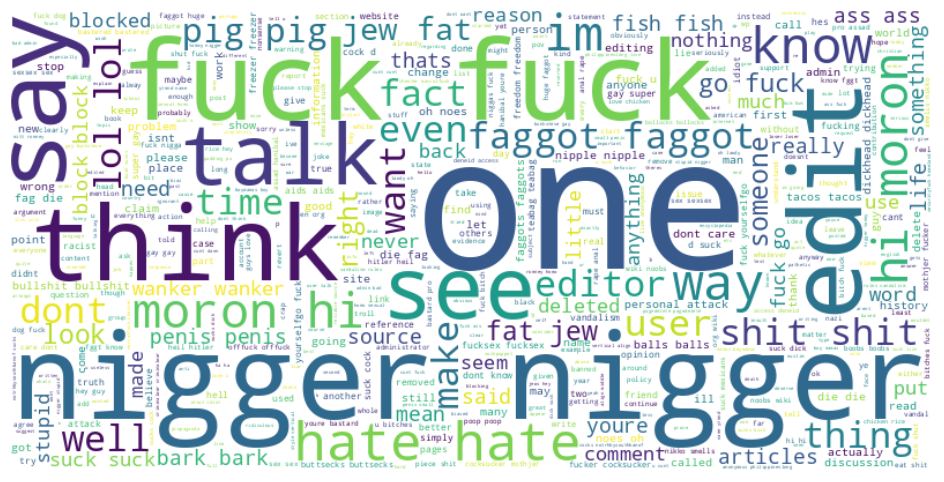

In [ ]:
# WORD CLOUD

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
toxic_df = dataset.filter(dataset.Category == 1)
comment_data = toxic_df.select("comment").rdd.flatMap(lambda x: x).collect()

# Remove duplicates from comment_data
comment_data = list(set(comment_data))
stop_words = StopWordsRemover().getStopWords()
stop_words += ["article", "page", "wikipedia","people"]

# Define a function to remove stop words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

# Apply the remove_stopwords function to the comment_data
filtered_comment_data = [remove_stopwords(comment) for comment in comment_data]

# Join the filtered text
filtered_text = " ".join(filtered_comment_data)

# Create the word cloud
wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
wc.generate(filtered_text)

# Plot the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


# wc = WordCloud(background_color="white", max_words=1000, stopwords=["article","page","wikipedia","but","have","thi","do","is","a","of","the","on","and","if","i","am","you","are","that","it","or","in","for","what","so","as","by","to","be","there","just","from","here","now","only"], width=800, height=400)
# wc.generate(" ".join(comment_data))

# # Plot the word cloud
# plt.figure(figsize=(12,6))
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()



In [ ]:
print(comment_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



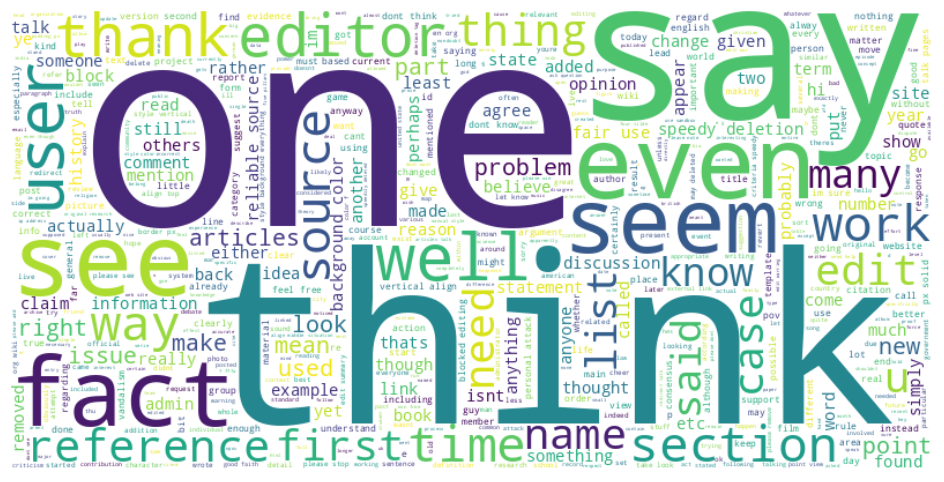

In [ ]:
nontoxic_df = dataset.filter(dataset.Category == 0)
nt_comment_data = nontoxic_df.select("comment").rdd.flatMap(lambda x: x).collect()

# Remove duplicates from comment_data
comment_data = list(set(nt_comment_data))

stop_words = StopWordsRemover().getStopWords()
stop_words += ["article", "page", "wikipedia","people"]

# Define a function to remove stop words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

# Apply the remove_stopwords function to the comment_data
filtered_comment_data = [remove_stopwords(comment) for comment in comment_data]

# Join the filtered text
filtered_text = " ".join(filtered_comment_data)

# Create the word cloud
wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
wc.generate(filtered_text)

# Plot the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()